# MovieLens-RAG-Recommendation-System (NLP + FAISS + LLM)

In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from wordcloud import WordCloud
import seaborn as sns
import faiss
import re
import unidecode

nlp=spacy.load("en_core_web_sm")

In [2]:
# Reading files
ratings=pd.read_csv('ratings.csv')
movies=pd.read_csv("movies.csv")
tags=pd.read_csv("tags.csv")
scores=pd.read_csv("genome-scores.csv")
g_tages=pd.read_csv("genome-tags.csv")

In [3]:
movies.shape

(86537, 3)

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746


In [7]:
scores.head()

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [8]:
g_tages.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [9]:
movie_ratings=movies.merge(ratings,on="movieId") # merging dataframes
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1225734739
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,835815971
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.0,974518024
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,3.0,1430666394
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,5.0,862500738
...,...,...,...,...,...,...
33832157,288967,State of Siege: Temple Attack (2021),Action|Drama,47791,3.5,1689748357
33832158,288971,Ouija Japan (2021),Action|Horror,98408,0.5,1689798322
33832159,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary,154483,4.0,1689812351
33832160,288977,Skinford: Death Sentence (2023),Crime|Thriller,291389,3.0,1689815902


In [10]:
tags

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746
...,...,...,...,...
2328310,330923,176599,politically correct,1507547491
2328311,330933,3317,coming of age,1351279384
2328312,330933,3317,sexuality,1351279389
2328313,330947,5782,Not Luc Besson,1154110902


In [11]:
tags.drop("timestamp",axis="columns",inplace=True)
tags["tag"]=tags["tag"].astype(str)
tags

,userId,movieId,tag
0,10,260,good vs evil
1,10,260,Harrison Ford
2,10,260,sci-fi
3,14,1221,Al Pacino
4,14,1221,mafia
...,...,...,...
2328310,330923,176599,politically correct
2328311,330933,3317,coming of age
2328312,330933,3317,sexuality
2328313,330947,5782,Not Luc Besson


In [12]:
tags[tags["movieId"]==1]['tag'].values

array(['animation', 'friendship', 'toys', ..., 'Pixar animation',
       'Tom Hanks', 'é˜®ä¸€é¸£'], dtype=object)

In [13]:
movie_tags = (                                          # extracting tags
    tags.groupby("movieId")["tag"]
        .apply(lambda x: " ".join(sorted(set(x))))
        .reset_index()
        .rename(columns={"tag": "tags"})
)
movie_tags

,movieId,tags
0,1,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
1,2,1860s 1960s 1990s 19th century 20th century 4k...
2,3,Ann Margaret Burgess Meredith CLV Daryl Hannah...
3,4,CLV based on novel or book characters chick fl...
4,5,4th wall CLV Comedy Diane Keaton Fantasy Steve...
...,...,...
53447,288765,apocalypse bad science plot holes post-apocaly...
53448,288779,Don Camillo Series
53449,288849,addiction animation short film
53450,288937,anime


In [14]:
movie_tags["tags"][0]

"1990s 2009 reissue in Stereoscopic 3-D 3 dimensional 3D 3d 55 movies every kid should see--Entertainment Weekly American Animation Animation Animation  BD-Video Best of Rotten Tomatoes: All Time Buzz Lightyear CG animation CGI CGI classic CLV Cartoon Comedy  DARING RESCUES DVD-Video Disney Disney animated feature Engaging Family cartoon HEROIC MISSION John Lasseter National Film Registry Os dois viram Oscar (Best Picture) Oscar (Special Achievement) Owned Pixar Pixar animation TOYS COME TO LIFE Tim Allen Tom Hanks Toy Story Tumey's To See Again Tumey's VHS TÃ©a Leoni does not star in this movie UNLIKELY FRIENDSHIPS USA Want Watched Woody accepting reality action action figure action figures ad for toys adventure affection alien almost favorite animated animated dog animated fictional tv commercial animation animmation antenna anthropomorphic toy anthropomorphism apology arcade arcade game arm asking directions astronaut audio flashback avi baby baby monitor backfire backyard bad guy b

In [15]:
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1225734739
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,835815971
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.0,974518024
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,3.0,1430666394
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,5.0,862500738
...,...,...,...,...,...,...
33832157,288967,State of Siege: Temple Attack (2021),Action|Drama,47791,3.5,1689748357
33832158,288971,Ouija Japan (2021),Action|Horror,98408,0.5,1689798322
33832159,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary,154483,4.0,1689812351
33832160,288977,Skinford: Death Sentence (2023),Crime|Thriller,291389,3.0,1689815902


In [16]:
df=movie_ratings.merge(movie_tags,on=["movieId"])
df

,movieId,title,genres,userId,rating,timestamp,tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1225734739,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,835815971,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.0,974518024,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,3.0,1430666394,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,5.0,862500738,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
...,...,...,...,...,...,...,...
33688651,288765,Bird Box Barcelona (2023),Horror|Thriller,236712,2.0,1689462634,apocalypse bad science plot holes post-apocaly...
33688652,288765,Bird Box Barcelona (2023),Horror|Thriller,243444,0.5,1689494308,apocalypse bad science plot holes post-apocaly...
33688653,288765,Bird Box Barcelona (2023),Horror|Thriller,276269,1.0,1689152119,apocalypse bad science plot holes post-apocaly...
33688654,288849,Colaholic (2018),(no genres listed),95007,3.0,1689268843,addiction animation short film


In [17]:
df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp', 'tags'], dtype='object')

In [18]:
df=df.groupby(['movieId', 'title', 'genres', 'tags'])['rating'].mean().to_frame().reset_index() # Aggregating ratings by average
df

,movieId,title,genres,tags,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...,3.893508
1,2,Jumanji (1995),Adventure|Children|Fantasy,1860s 1960s 1990s 19th century 20th century 4k...,3.278179
2,3,Grumpier Old Men (1995),Comedy|Romance,Ann Margaret Burgess Meredith CLV Daryl Hannah...,3.171271
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,CLV based on novel or book characters chick fl...,2.868395
4,5,Father of the Bride Part II (1995),Comedy,4th wall CLV Comedy Diane Keaton Fantasy Steve...,3.076957
...,...,...,...,...,...
50149,288747,LOLA (2023),Drama|Sci-Fi,Nazis World War II black and white interesting...,3.250000
50150,288753,The Deep Web: Murdershow (2023),Horror|Thriller,deep web horror thriller,1.714286
50151,288765,Bird Box Barcelona (2023),Horror|Thriller,apocalypse bad science plot holes post-apocaly...,2.468750
50152,288849,Colaholic (2018),(no genres listed),addiction animation short film,3.000000


In [19]:
df.to_csv("merge_movie_data.csv")

In [20]:
#df=pd.read_csv("merge_movie_data")

In [21]:
genres=df["genres"].str.replace("|",",").values
genres

array(['Adventure,Animation,Children,Comedy,Fantasy',
       'Adventure,Children,Fantasy', 'Comedy,Romance', ...,
       'Horror,Thriller', '(no genres listed)', 'Drama'], dtype=object)

In [22]:
g=set()
for x in genres:
    if x!='(no genres listed)':
        g.update(x.split(","))
g=list(g)
g

['Documentary',
 'Horror',
 'Drama',
 'Sci-Fi',
 'Children',
 'Fantasy',
 'Animation',
 'Thriller',
 'Romance',
 'Film-Noir',
 'Crime',
 'War',
 'Action',
 'IMAX',
 'Mystery',
 'Comedy',
 'Adventure',
 'Musical',
 'Western']

In [23]:
for x in range(len(g)):
    g[x]=g[x].lower()
g

['documentary',
 'horror',
 'drama',
 'sci-fi',
 'children',
 'fantasy',
 'animation',
 'thriller',
 'romance',
 'film-noir',
 'crime',
 'war',
 'action',
 'imax',
 'mystery',
 'comedy',
 'adventure',
 'musical',
 'western']

## Pre-processing

In [24]:
# Pre-processing text data
def website(x):
    return re.findall(r"https?://\S+|www\S+",x)

In [25]:
df["websites"]=df["tags"].apply(website)
df["websites"].value_counts()

websites
[]                                                                                                                                                                                                                                                                                                                                                                                50119
[https://movielens.org/tag/:animation]                                                                                                                                                                                                                                                                                                                                                1
[http://www.tu.tv/videos/el-hombre-que-plantaba-arboles]                                                                                                                                                                                       

In [26]:
def htags(x):
    return re.findall(r">|<", x)

In [27]:
df["html"]=df["tags"].apply(htags)
df["html"].value_counts()

html
[]        50075
[<]          40
[>]          36
[<, >]        2
[>, >]        1
Name: count, dtype: int64

In [28]:
df["genres"].value_counts()

genres
Drama                                              7467
Comedy                                             4251
Documentary                                        4061
(no genres listed)                                 2251
Comedy|Drama                                       1956
                                                   ... 
Adventure|Documentary|Drama|War                       1
Action|Adventure|Drama|Romance|Thriller|Western       1
Comedy|Horror|IMAX                                    1
Action|Comedy|Sci-Fi|IMAX                             1
Animation|Children|Comedy|Fantasy|Romance             1
Name: count, Length: 1599, dtype: int64

In [29]:
df["genres"]=df["genres"].str.replace("|"," ")
df

,movieId,title,genres,tags,rating,websites,html
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...,3.893508,[https://movielens.org/tag/:animation],[]
1,2,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th century 4k...,3.278179,[],[]
2,3,Grumpier Old Men (1995),Comedy Romance,Ann Margaret Burgess Meredith CLV Daryl Hannah...,3.171271,[],[]
3,4,Waiting to Exhale (1995),Comedy Drama Romance,CLV based on novel or book characters chick fl...,2.868395,[],[]
4,5,Father of the Bride Part II (1995),Comedy,4th wall CLV Comedy Diane Keaton Fantasy Steve...,3.076957,[],[]
...,...,...,...,...,...,...,...
50149,288747,LOLA (2023),Drama Sci-Fi,Nazis World War II black and white interesting...,3.250000,[],[]
50150,288753,The Deep Web: Murdershow (2023),Horror Thriller,deep web horror thriller,1.714286,[],[]
50151,288765,Bird Box Barcelona (2023),Horror Thriller,apocalypse bad science plot holes post-apocaly...,2.468750,[],[]
50152,288849,Colaholic (2018),(no genres listed),addiction animation short film,3.000000,[],[]


In [30]:
def regx(x):
    x = unidecode.unidecode(x)
    clean = re.sub(r"https?://\S+|www\S+","",x)       # remove URLs
    clean = re.sub(r"[<>]"," ",clean)                 # remove <>
    clean = re.sub(r"(\d)\s*d\b", r"\1d", clean)      # fix 3d / 3 d

    clean = re.sub(r"(\w)\s+'s\b", r"\1's", clean)

    clean = re.sub(r"[^\x00-\x7F]+", " ", clean)      # remove non-ascii
    clean = re.sub(r"[^0-9A-Za-z\s']", " ", clean)    # keep apostrophes
    clean = re.sub(r"\s+"," ",clean).lower().strip()  # collapse spaces

    tokens = clean.split()
    unique_tokens = list(dict.fromkeys(tokens))
    return " ".join(unique_tokens)

In [31]:
df["tags"]=df["tags"].apply(regx)

In [32]:
df

,movieId,title,genres,tags,rating,websites,html
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in stereoscopic 3 d dimensi...,3.893508,[https://movielens.org/tag/:animation],[]
1,2,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th 4k adaptat...,3.278179,[],[]
2,3,Grumpier Old Men (1995),Comedy Romance,ann margaret burgess meredith clv daryl hannah...,3.171271,[],[]
3,4,Waiting to Exhale (1995),Comedy Drama Romance,clv based on novel or book characters chick fl...,2.868395,[],[]
4,5,Father of the Bride Part II (1995),Comedy,4th wall clv comedy diane keaton fantasy steve...,3.076957,[],[]
...,...,...,...,...,...,...,...
50149,288747,LOLA (2023),Drama Sci-Fi,nazis world war ii black and white interesting...,3.250000,[],[]
50150,288753,The Deep Web: Murdershow (2023),Horror Thriller,deep web horror thriller,1.714286,[],[]
50151,288765,Bird Box Barcelona (2023),Horror Thriller,apocalypse bad science plot holes post apocaly...,2.468750,[],[]
50152,288849,Colaholic (2018),(no genres listed),addiction animation short film,3.000000,[],[]


In [33]:
def spacy_clean(x):
    cleaned=[]
    for docs in nlp.pipe(x,batch_size=500):
        tokens=[token.text for token in docs if not token.is_space and not token.is_punct]
        cleaned.append(" ".join(tokens))
    return cleaned

In [34]:
df["clean_tags"]=spacy_clean(df["tags"])

In [35]:
df

,movieId,title,genres,tags,rating,websites,html,clean_tags
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in stereoscopic 3 d dimensi...,3.893508,[https://movielens.org/tag/:animation],[],1990s 2009 reissue in stereoscopic 3 d dimensi...
1,2,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th 4k adaptat...,3.278179,[],[],1860s 1960s 1990s 19th century 20th 4k adaptat...
2,3,Grumpier Old Men (1995),Comedy Romance,ann margaret burgess meredith clv daryl hannah...,3.171271,[],[],ann margaret burgess meredith clv daryl hannah...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,clv based on novel or book characters chick fl...,2.868395,[],[],clv based on novel or book characters chick fl...
4,5,Father of the Bride Part II (1995),Comedy,4th wall clv comedy diane keaton fantasy steve...,3.076957,[],[],4th wall clv comedy diane keaton fantasy steve...
...,...,...,...,...,...,...,...,...
50149,288747,LOLA (2023),Drama Sci-Fi,nazis world war ii black and white interesting...,3.250000,[],[],nazis world war ii black and white interesting...
50150,288753,The Deep Web: Murdershow (2023),Horror Thriller,deep web horror thriller,1.714286,[],[],deep web horror thriller
50151,288765,Bird Box Barcelona (2023),Horror Thriller,apocalypse bad science plot holes post apocaly...,2.468750,[],[],apocalypse bad science plot holes post apocaly...
50152,288849,Colaholic (2018),(no genres listed),addiction animation short film,3.000000,[],[],addiction animation short film


In [36]:
df.columns

Index(['movieId', 'title', 'genres', 'tags', 'rating', 'websites', 'html',
       'clean_tags'],
      dtype='object')

In [37]:
df=df[['title', 'genres', 'tags', 'rating', 'clean_tags']]
df

,title,genres,tags,rating,clean_tags
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in stereoscopic 3 d dimensi...,3.893508,1990s 2009 reissue in stereoscopic 3 d dimensi...
1,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th 4k adaptat...,3.278179,1860s 1960s 1990s 19th century 20th 4k adaptat...
2,Grumpier Old Men (1995),Comedy Romance,ann margaret burgess meredith clv daryl hannah...,3.171271,ann margaret burgess meredith clv daryl hannah...
3,Waiting to Exhale (1995),Comedy Drama Romance,clv based on novel or book characters chick fl...,2.868395,clv based on novel or book characters chick fl...
4,Father of the Bride Part II (1995),Comedy,4th wall clv comedy diane keaton fantasy steve...,3.076957,4th wall clv comedy diane keaton fantasy steve...
...,...,...,...,...,...
50149,LOLA (2023),Drama Sci-Fi,nazis world war ii black and white interesting...,3.250000,nazis world war ii black and white interesting...
50150,The Deep Web: Murdershow (2023),Horror Thriller,deep web horror thriller,1.714286,deep web horror thriller
50151,Bird Box Barcelona (2023),Horror Thriller,apocalypse bad science plot holes post apocaly...,2.468750,apocalypse bad science plot holes post apocaly...
50152,Colaholic (2018),(no genres listed),addiction animation short film,3.000000,addiction animation short film


In [38]:
df["clean_tags"].values[0]

"1990s 2009 reissue in stereoscopic 3 d dimensional 3d 55 movies every kid should see entertainment weekly american animation bd video best of rotten tomatoes all time buzz lightyear cg cgi classic clv cartoon comedy daring rescues dvd disney animated feature engaging family heroic mission john lasseter national film registry os dois viram oscar picture special achievement owned pixar toys come to life tim allen tom hanks toy story tumey 's again vhs ta c a leoni does not star this movie unlikely friendships usa want watched woody accepting reality action figure figures ad for adventure affection alien almost favorite dog fictional tv commercial animmation antenna anthropomorphic anthropomorphism apology arcade game arm asking directions astronaut audio flashback avi baby monitor backfire backyard bad guy ballet flats banister battery battleship beautiful bed bedroom binoculars biohazard sign birthday party present blinds blockbuster bo peep character bouncy ball boy next door brat bra

In [39]:
def r(x):
    return round(x,2)

In [40]:
df["rating"]=df["rating"].apply(r)
df.head()

/tmp/ipykernel_9723/3696428323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rating"]=df["rating"].apply(r)


,title,genres,tags,rating,clean_tags
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in stereoscopic 3 d dimensi...,3.89,1990s 2009 reissue in stereoscopic 3 d dimensi...
1,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th 4k adaptat...,3.28,1860s 1960s 1990s 19th century 20th 4k adaptat...
2,Grumpier Old Men (1995),Comedy Romance,ann margaret burgess meredith clv daryl hannah...,3.17,ann margaret burgess meredith clv daryl hannah...
3,Waiting to Exhale (1995),Comedy Drama Romance,clv based on novel or book characters chick fl...,2.87,clv based on novel or book characters chick fl...
4,Father of the Bride Part II (1995),Comedy,4th wall clv comedy diane keaton fantasy steve...,3.08,4th wall clv comedy diane keaton fantasy steve...


In [41]:
# Concatenation of all columns into a single string for RAG-system
df["doc_text"]="Title: "+df["title"]+"; Genres: "+df["genres"]+"; Avg. Rating: "+df["rating"].astype(str)+"; Tags: "+df["clean_tags"]

/tmp/ipykernel_9723/3436800627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["doc_text"]="Title: "+df["title"]+"; Genres: "+df["genres"]+"; Avg. Rating: "+df["rating"].astype(str)+"; Tags: "+df["clean_tags"]


In [42]:
df

,title,genres,tags,rating,clean_tags,doc_text
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in stereoscopic 3 d dimensi...,3.89,1990s 2009 reissue in stereoscopic 3 d dimensi...,Title: Toy Story (1995); Genres: Adventure Ani...
1,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th 4k adaptat...,3.28,1860s 1960s 1990s 19th century 20th 4k adaptat...,Title: Jumanji (1995); Genres: Adventure Child...
2,Grumpier Old Men (1995),Comedy Romance,ann margaret burgess meredith clv daryl hannah...,3.17,ann margaret burgess meredith clv daryl hannah...,Title: Grumpier Old Men (1995); Genres: Comedy...
3,Waiting to Exhale (1995),Comedy Drama Romance,clv based on novel or book characters chick fl...,2.87,clv based on novel or book characters chick fl...,Title: Waiting to Exhale (1995); Genres: Comed...
4,Father of the Bride Part II (1995),Comedy,4th wall clv comedy diane keaton fantasy steve...,3.08,4th wall clv comedy diane keaton fantasy steve...,Title: Father of the Bride Part II (1995); Gen...
...,...,...,...,...,...,...
50149,LOLA (2023),Drama Sci-Fi,nazis world war ii black and white interesting...,3.25,nazis world war ii black and white interesting...,Title: LOLA (2023); Genres: Drama Sci-Fi; Avg....
50150,The Deep Web: Murdershow (2023),Horror Thriller,deep web horror thriller,1.71,deep web horror thriller,Title: The Deep Web: Murdershow (2023); Genres...
50151,Bird Box Barcelona (2023),Horror Thriller,apocalypse bad science plot holes post apocaly...,2.47,apocalypse bad science plot holes post apocaly...,Title: Bird Box Barcelona (2023); Genres: Horr...
50152,Colaholic (2018),(no genres listed),addiction animation short film,3.00,addiction animation short film,Title: Colaholic (2018); Genres: (no genres li...


In [43]:
df["doc_text"].values[0]

"Title: Toy Story (1995); Genres: Adventure Animation Children Comedy Fantasy; Avg. Rating: 3.89; Tags: 1990s 2009 reissue in stereoscopic 3 d dimensional 3d 55 movies every kid should see entertainment weekly american animation bd video best of rotten tomatoes all time buzz lightyear cg cgi classic clv cartoon comedy daring rescues dvd disney animated feature engaging family heroic mission john lasseter national film registry os dois viram oscar picture special achievement owned pixar toys come to life tim allen tom hanks toy story tumey 's again vhs ta c a leoni does not star this movie unlikely friendships usa want watched woody accepting reality action figure figures ad for adventure affection alien almost favorite dog fictional tv commercial animmation antenna anthropomorphic anthropomorphism apology arcade game arm asking directions astronaut audio flashback avi baby monitor backfire backyard bad guy ballet flats banister battery battleship beautiful bed bedroom binoculars biohaz

In [44]:
temp_df=df.copy()
temp_df

,title,genres,tags,rating,clean_tags,doc_text
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in stereoscopic 3 d dimensi...,3.89,1990s 2009 reissue in stereoscopic 3 d dimensi...,Title: Toy Story (1995); Genres: Adventure Ani...
1,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th 4k adaptat...,3.28,1860s 1960s 1990s 19th century 20th 4k adaptat...,Title: Jumanji (1995); Genres: Adventure Child...
2,Grumpier Old Men (1995),Comedy Romance,ann margaret burgess meredith clv daryl hannah...,3.17,ann margaret burgess meredith clv daryl hannah...,Title: Grumpier Old Men (1995); Genres: Comedy...
3,Waiting to Exhale (1995),Comedy Drama Romance,clv based on novel or book characters chick fl...,2.87,clv based on novel or book characters chick fl...,Title: Waiting to Exhale (1995); Genres: Comed...
4,Father of the Bride Part II (1995),Comedy,4th wall clv comedy diane keaton fantasy steve...,3.08,4th wall clv comedy diane keaton fantasy steve...,Title: Father of the Bride Part II (1995); Gen...
...,...,...,...,...,...,...
50149,LOLA (2023),Drama Sci-Fi,nazis world war ii black and white interesting...,3.25,nazis world war ii black and white interesting...,Title: LOLA (2023); Genres: Drama Sci-Fi; Avg....
50150,The Deep Web: Murdershow (2023),Horror Thriller,deep web horror thriller,1.71,deep web horror thriller,Title: The Deep Web: Murdershow (2023); Genres...
50151,Bird Box Barcelona (2023),Horror Thriller,apocalypse bad science plot holes post apocaly...,2.47,apocalypse bad science plot holes post apocaly...,Title: Bird Box Barcelona (2023); Genres: Horr...
50152,Colaholic (2018),(no genres listed),addiction animation short film,3.00,addiction animation short film,Title: Colaholic (2018); Genres: (no genres li...


In [45]:
all_genres=[]
for x in temp_df["genres"].values:
    if x!="(no genres listed)":
        all_genres.extend(x.split())
all_genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Adventure',
 'Children',
 'Fantasy',
 'Comedy',
 'Romance',
 'Comedy',
 'Drama',
 'Romance',
 'Comedy',
 'Action',
 'Crime',
 'Thriller',
 'Comedy',
 'Romance',
 'Adventure',
 'Children',
 'Action',
 'Action',
 'Adventure',
 'Thriller',
 'Comedy',
 'Drama',
 'Romance',
 'Comedy',
 'Horror',
 'Adventure',
 'Animation',
 'Children',
 'Drama',
 'Action',
 'Adventure',
 'Romance',
 'Crime',
 'Drama',
 'Drama',
 'Romance',
 'Comedy',
 'Comedy',
 'Action',
 'Comedy',
 'Crime',
 'Drama',
 'Thriller',
 'Comedy',
 'Crime',
 'Thriller',
 'Crime',
 'Drama',
 'Horror',
 'Mystery',
 'Thriller',
 'Action',
 'Crime',
 'Thriller',
 'Drama',
 'Sci-Fi',
 'Drama',
 'Romance',
 'Drama',
 'Children',
 'Drama',
 'Drama',
 'Romance',
 'Adventure',
 'Drama',
 'Fantasy',
 'Mystery',
 'Sci-Fi',
 'Crime',
 'Drama',
 'Drama',
 'Mystery',
 'Sci-Fi',
 'Thriller',
 'Adventure',
 'Romance',
 'IMAX',
 'Children',
 'Drama',
 'Drama',
 'Romance',
 'Crime'

In [46]:
uniq_genres=list(set(all_genres))
uniq_genres

['Documentary',
 'Horror',
 'Drama',
 'Sci-Fi',
 'Children',
 'Fantasy',
 'Animation',
 'Thriller',
 'Romance',
 'Film-Noir',
 'Crime',
 'War',
 'Action',
 'IMAX',
 'Mystery',
 'Comedy',
 'Adventure',
 'Musical',
 'Western']

In [47]:
genre_df=pd.DataFrame({"Genre":uniq_genres,"Count":[all_genres.count(x) for x in uniq_genres]}).sort_values(by="Count",ascending=False)

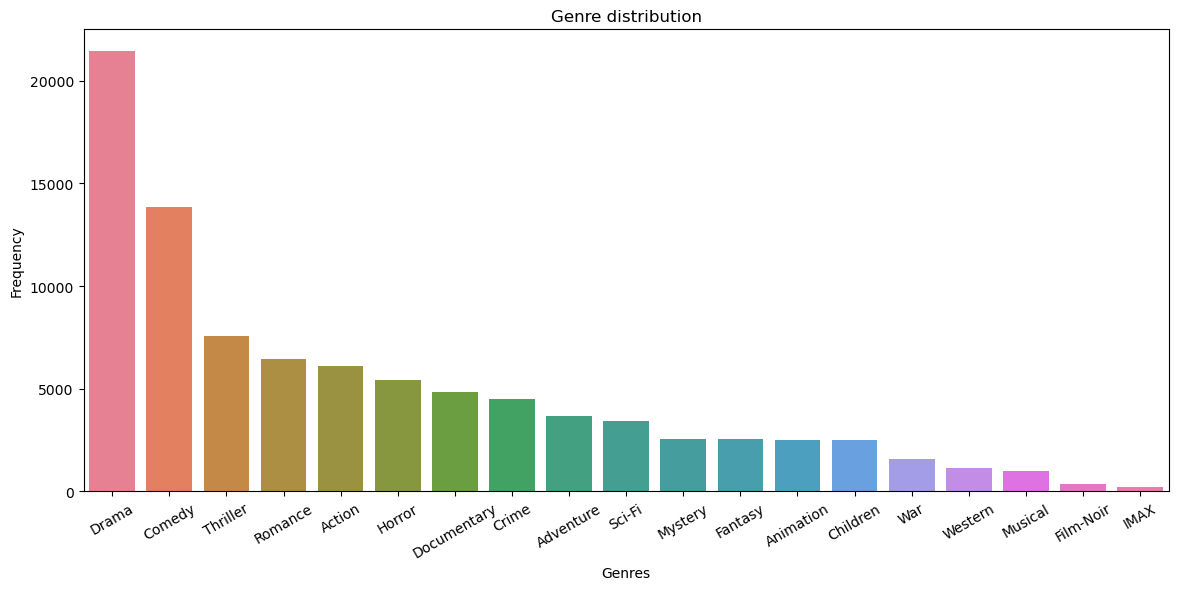

In [48]:
plt.figure(figsize=(14,6))
sns.barplot(x="Genre",y="Count",hue="Genre",data=genre_df)
plt.title("Genre distribution")
plt.xlabel("Genres")
plt.ylabel("Frequency")
plt.xticks(rotation=30)
plt.show()

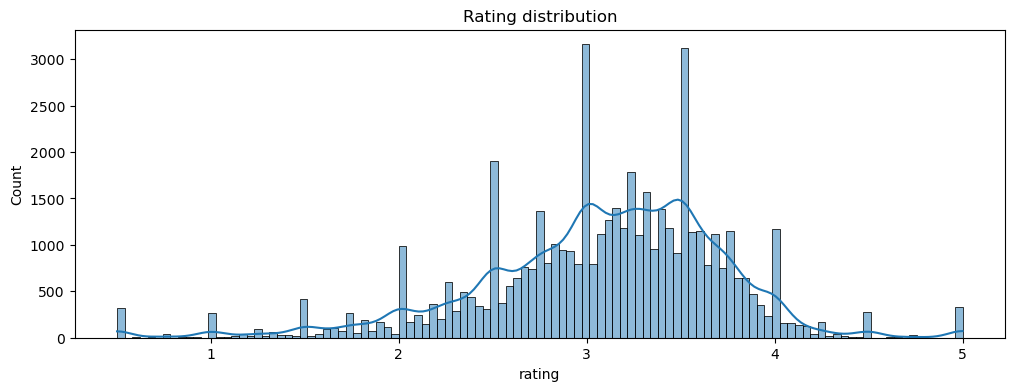

In [49]:
plt.figure(figsize=(12,4))
sns.histplot(data=temp_df,x=temp_df["rating"],kde=True)
plt.title("Rating distribution")
plt.show()

In [50]:
temp_df["rating"].median()

3.16

In [51]:
pos_df=temp_df[temp_df["rating"]>=temp_df["rating"].median()] # Assuming rating >= median are positive reviews
pos_df

,title,genres,tags,rating,clean_tags,doc_text
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in stereoscopic 3 d dimensi...,3.89,1990s 2009 reissue in stereoscopic 3 d dimensi...,Title: Toy Story (1995); Genres: Adventure Ani...
1,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th 4k adaptat...,3.28,1860s 1960s 1990s 19th century 20th 4k adaptat...,Title: Jumanji (1995); Genres: Adventure Child...
2,Grumpier Old Men (1995),Comedy Romance,ann margaret burgess meredith clv daryl hannah...,3.17,ann margaret burgess meredith clv daryl hannah...,Title: Grumpier Old Men (1995); Genres: Comedy...
5,Heat (1995),Action Crime Thriller,1 7 5 filmaffinity action al pacino vs robert ...,3.86,1 7 5 filmaffinity action al pacino vs robert ...,Title: Heat (1995); Genres: Action Crime Thril...
6,Sabrina (1995),Comedy Romance,clv drama greg kinnear harrison ford julia orm...,3.37,clv drama greg kinnear harrison ford julia orm...,Title: Sabrina (1995); Genres: Comedy Romance;...
...,...,...,...,...,...,...
50142,A Radiant Girl (2022),Drama War,cannes 2021 france world war ii bittersweet co...,4.00,cannes 2021 france world war ii bittersweet co...,Title: A Radiant Girl (2022); Genres: Drama Wa...
50143,Everybody's Oma (2022),Documentary,alzheimer's disease,4.50,alzheimer 's disease,Title: Everybody's Oma (2022); Genres: Documen...
50144,Sabotage,(no genres listed),animation auschwitz birkenau concentration cam...,3.50,animation auschwitz birkenau concentration cam...,Title: Sabotage; Genres: (no genres listed); A...
50148,Esperando a Dalí (2023),Comedy Romance,1974 cadaques gala dali guardia civil salvador...,3.50,1974 cadaques gala dali guardia civil salvador...,Title: Esperando a Dalí (2023); Genres: Comedy...


In [52]:
def clean_text(x):
    clean = x

    clean = re.sub(r"\b(\d+)\s*[a-zA-Z]\b", " ", clean)

    clean = re.sub(r"\b[a-zA-Z]+\d+\b", " ", clean)

    clean = clean.replace("'", " ")

    clean = re.sub(r"\b[a-zA-Z]\b", " ", clean)
    clean = re.sub(r"[^0-9A-Za-z\s]", " ", clean)

    clean = re.sub(r"\s+", " ", clean).strip().lower()

    tokens = clean.split()
    unique_tokens = list(dict.fromkeys(tokens))

    return " ".join(unique_tokens)


In [53]:
pos_df["clean_tags"]=pos_df['clean_tags'].apply(clean_text)

/tmp/ipykernel_9723/414444472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df["clean_tags"]=pos_df['clean_tags'].apply(clean_text)


In [54]:
pos_df["clean_tags"].values[0]

'2009 reissue in stereoscopic dimensional 55 movies every kid should see entertainment weekly american animation bd video best of rotten tomatoes all time buzz lightyear cg cgi classic clv cartoon comedy daring rescues dvd disney animated feature engaging family heroic mission john lasseter national film registry os dois viram oscar picture special achievement owned pixar toys come to life tim allen tom hanks toy story tumey again vhs ta leoni does not star this movie unlikely friendships usa want watched woody accepting reality action figure figures ad for adventure affection alien almost favorite dog fictional tv commercial animmation antenna anthropomorphic anthropomorphism apology arcade game arm asking directions astronaut audio flashback avi baby monitor backfire backyard bad guy ballet flats banister battery battleship beautiful bed bedroom binoculars biohazard sign birthday party present blinds blockbuster bo peep character bouncy ball boy next door brat brawl bright brother si

In [55]:
positive_tags=pos_df["clean_tags"].values.tolist()

In [56]:
len(positive_tags)

25219

In [57]:
positive_tags

['2009 reissue in stereoscopic dimensional 55 movies every kid should see entertainment weekly american animation bd video best of rotten tomatoes all time buzz lightyear cg cgi classic clv cartoon comedy daring rescues dvd disney animated feature engaging family heroic mission john lasseter national film registry os dois viram oscar picture special achievement owned pixar toys come to life tim allen tom hanks toy story tumey again vhs ta leoni does not star this movie unlikely friendships usa want watched woody accepting reality action figure figures ad for adventure affection alien almost favorite dog fictional tv commercial animmation antenna anthropomorphic anthropomorphism apology arcade game arm asking directions astronaut audio flashback avi baby monitor backfire backyard bad guy ballet flats banister battery battleship beautiful bed bedroom binoculars biohazard sign birthday party present blinds blockbuster bo peep character bouncy ball boy next door brat brawl bright brother s

In [58]:
common_words=["director","movie","film",'movies','films','seen']

In [59]:
positive_cleaned_tags = [" ".join([w for w in s.split() if w not in common_words]) for s in positive_tags]

In [60]:
positive_tags=" ".join(positive_cleaned_tags)

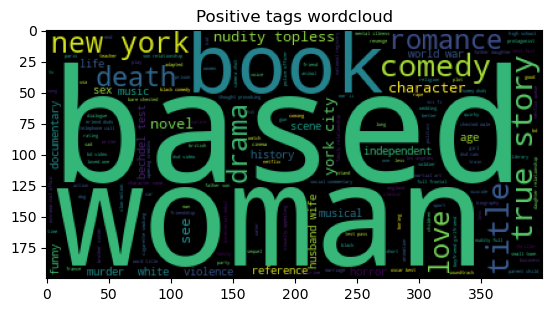

In [61]:
pos_wc=WordCloud(max_words=1000,background_color="black").generate(positive_tags) # Wordcloud to see dominant words
plt.title("Positive tags wordcloud")
plt.imshow(pos_wc)

In [62]:
neg_df=temp_df[temp_df["rating"]<temp_df["rating"].median()] # Assuming rating <3 are bad reviews
neg_df

,title,genres,tags,rating,clean_tags,doc_text
3,Waiting to Exhale (1995),Comedy Drama Romance,clv based on novel or book characters chick fl...,2.87,clv based on novel or book characters chick fl...,Title: Waiting to Exhale (1995); Genres: Comed...
4,Father of the Bride Part II (1995),Comedy,4th wall clv comedy diane keaton fantasy steve...,3.08,4th wall clv comedy diane keaton fantasy steve...,Title: Father of the Bride Part II (1995); Gen...
7,Tom and Huck (1995),Adventure Children,19th century disney library system mark twain ...,3.12,19th century disney library system mark twain ...,Title: Tom and Huck (1995); Genres: Adventure ...
8,Sudden Death (1995),Action,1990s action clv can't remember jean claude va...,3.00,1990s action clv ca n't remember jean claude v...,Title: Sudden Death (1995); Genres: Action; Av...
11,Dracula: Dead and Loving It (1995),Comedy Horror,bd r leslie nielsen mel brooks abandoned chape...,2.68,bd r leslie nielsen mel brooks abandoned chape...,Title: Dracula: Dead and Loving It (1995); Gen...
...,...,...,...,...,...,...
50147,A Corsican Summer (2022),Drama,ataraxia boredom corsica slow paced summer vil...,1.50,ataraxia boredom corsica slow paced summer vil...,Title: A Corsican Summer (2022); Genres: Drama...
50150,The Deep Web: Murdershow (2023),Horror Thriller,deep web horror thriller,1.71,deep web horror thriller,Title: The Deep Web: Murdershow (2023); Genres...
50151,Bird Box Barcelona (2023),Horror Thriller,apocalypse bad science plot holes post apocaly...,2.47,apocalypse bad science plot holes post apocaly...,Title: Bird Box Barcelona (2023); Genres: Horr...
50152,Colaholic (2018),(no genres listed),addiction animation short film,3.00,addiction animation short film,Title: Colaholic (2018); Genres: (no genres li...


In [63]:
negative_tags=neg_df["tags"].apply(clean_text)
negative_tags=neg_df["tags"].values.tolist()
negative_cleaned_tags = [" ".join([w for w in s.split() if w not in common_words]) for s in negative_tags]
negative_tags=" ".join(negative_cleaned_tags)

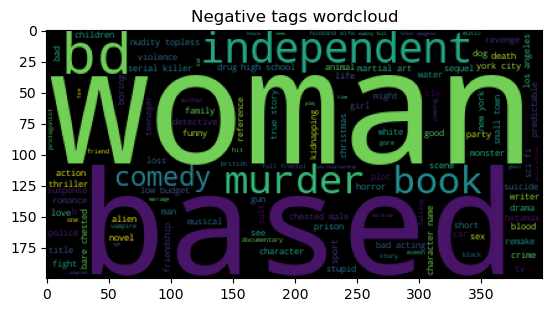

In [64]:
neg_wc=WordCloud(max_words=1000,background_color="black").generate(negative_tags)
plt.title("Negative tags wordcloud")
plt.imshow(neg_wc)

In [65]:
df["doc_text"][0]

"Title: Toy Story (1995); Genres: Adventure Animation Children Comedy Fantasy; Avg. Rating: 3.89; Tags: 1990s 2009 reissue in stereoscopic 3 d dimensional 3d 55 movies every kid should see entertainment weekly american animation bd video best of rotten tomatoes all time buzz lightyear cg cgi classic clv cartoon comedy daring rescues dvd disney animated feature engaging family heroic mission john lasseter national film registry os dois viram oscar picture special achievement owned pixar toys come to life tim allen tom hanks toy story tumey 's again vhs ta c a leoni does not star this movie unlikely friendships usa want watched woody accepting reality action figure figures ad for adventure affection alien almost favorite dog fictional tv commercial animmation antenna anthropomorphic anthropomorphism apology arcade game arm asking directions astronaut audio flashback avi baby monitor backfire backyard bad guy ballet flats banister battery battleship beautiful bed bedroom binoculars biohaz

In [10]:
all_docs=df["doc_text"].values

In [ ]:
#df.to_csv('processed_movie_data.csv') # saving the final dataframe into csv file

# Model Building

In [ ]:
from sentence_transformers import SentenceTransformer
model=SentenceTransformer("all-MiniLM-L6-v2")

embeddings=model.encode(all_docs,convert_to_numpy=True) # Vectorization of text data
embeddings

/home/abhi/miniforge3/envs/tf_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-15 09:36:54.185982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-15 09:36:54.205091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-15 09:36:54.211389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-15 09:36:54.227913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow 

In [69]:
embeddings.shape

(50154, 384)

In [70]:
index=faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

In [78]:
faiss.write_index(index,"final_movie_index.faiss")    # saving the index

In [72]:
q="good scifi"  # sample test case

q_v=model.encode(q)

In [73]:
dist,ind=index.search(q_v.reshape(1,-1),k=10)

In [74]:
ind[0]

array([33442, 46262, 38046, 15052, 46855, 48454, 36889, 47781, 49441,
       38662])

In [75]:
for x in ind[0]:
    print(all_docs[x])

Title: Sunspring (2016); Genres: Sci-Fi; Avg. Rating: 1.8; Tags: experimental nonsense
Title: Sync (2014); Genres: Action Sci-Fi; Avg. Rating: 4.17; Tags: action scifi
Title: Anti Matter (2016); Genres: Sci-Fi; Avg. Rating: 2.95; Tags: plot twist sci fi amnesia cloning memory loss teleportation
Title: Scientist, The (2010); Genres: Drama; Avg. Rating: 2.71; Tags: philosophy physics
Title: Minor Premise (2020); Genres: Sci-Fi Thriller; Avg. Rating: 2.89; Tags: 2020 sitges bad science plot holes psychological e thriller psycolo sci fi fiction
Title: Grey Eyes (2018); Genres: Action Sci-Fi; Avg. Rating: 2.75; Tags: bad science nonsense plot holes
Title: Realive (2016); Genres: Sci-Fi; Avg. Rating: 3.07; Tags: drama sci fi boring cancer cryogenics death depression experiment fear future hunks philosophical pretentious pretty woman suicide unoriginal weak plot
Title: Cosmic Sin (2021); Genres: Action Sci-Fi; Avg. Rating: 1.6; Tags: bad acting plot science
Title: Outpost (2020); Genres: Sci-

In [3]:
from groq import Groq
import all_api

client=Groq(api_key=all_api.groq_api)

## Recommendation Engine

In [13]:
def recommend_movies(user_text):
    user_vector=model.encode(user_text)
    dis,ind=index.search(user_vector.reshape(1,-1),k=10)
    retirved_chunks=[]
    for x in ind[0]:
        retirved_chunks.append(all_docs[x])
    full_string=" ".join(retirved_chunks)
    completion = client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages=[
        {
            "role": "system",
            "content": (
                "You are a movie recommendation assistant for a RAG system.\n"
                "You MUST use only the information provided in the retrieved context "
                "(Movie metadata). Do NOT hallucinate new movie titles, years, or ratings.\n"
                "If the context does not contain enough information to answer, respond with:\n"
                "\"No relevant recommendations found in the database.\"\n\n"
                "OUTPUT FORMAT:\n"
                "1. First, list the recommended movies (if any), numbered one per line, in natural language.\n"
                "   Each line MUST follow this format exactly:\n"
                "   Title (Year) - Avg Rating: <rating>\n"
                "   - Use the year from the title if present (e.g., \"Heat (1995)\").\n"
                "   - Use the rating from the context (do not invent values).\n"
                "   - Sort all recommendations in STRICTLY descending order of rating.\n"
                "2. After listing all recommendations, add a blank line.\n"
                "3. On the LAST line, provide a self-evaluation of your answer, in this format:\n"
                "   Score: X/5 - <short explanation grounded in the context>\n\n"
                "SCORING GUIDELINES:\n"
                " - 5/5: All recommended movies are clearly supported by the context, correctly sorted "
                "by rating, and highly relevant to the user query.\n"
                " - 4/5: Mostly correct and grounded, maybe a minor issue (e.g., borderline relevance "
                "or slight ordering ambiguity).\n"
                " - 3/5: Some relevant movies, but missing key ones or minor mistakes.\n"
                " - 2/5: Several mistakes, missing important context, or partially ungrounded.\n"
                " - 1/5: Largely incorrect, hallucinated, or not using the context properly.\n\n"
                "Do NOT restate the question. Do NOT output JSON. Only follow the format above."
            )
        },
        {
            "role": "user",
            "content": (
                f"Movie metadata (retrieved context):\n{full_string}\n\n"
                f"User query: {user_text}\n\n"
                "Based only on the retrieved context, recommend movies that best match the user query."
            )
        }
    ],
    temperature=0.0,
    max_completion_tokens=1024,
    top_p=1,
)

    results=completion.choices[0].message.content
    print(results)


In [16]:
recommend_movies(input("Enter keyword,plot,genre"))

1. Avengers: Infinity War - Part II (2019) - Avg Rating: 3.9
2. Spider-Man: No Way Home (2021) - Avg Rating: 3.81
3. The Avengers (2012) - Avg Rating: 3.74
4. Marvel Studios: Assembling a Universe (2014) - Avg Rating: 3.53
5. Marvel: 75 Years, From Pulp to Pop! (2014) - Avg Rating: 3.36
6. Team Thor: Part 2 (2017) - Avg Rating: 3.08

 

Score: 5/5 - All recommended movies are clearly supported by the context, correctly sorted by rating, and highly relevant to the user query.
